#Step 1 - Import PySpark


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.3.4/spark-3.3.4-bin-hadoop3.tgz
!tar -xvf spark-3.3.4-bin-hadoop3.tgz
!pip install findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.4-bin-hadoop3"

import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

sc = spark.sparkContext

--2024-01-04 21:22:52--  https://dlcdn.apache.org/spark/spark-3.3.4/spark-3.3.4-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299467603 (286M) [application/x-gzip]
Saving to: ‘spark-3.3.4-bin-hadoop3.tgz.1’

spark-3.3.4-bin-had 100%[===================>] 285.59M   139MB/s    in 2.1s    

2024-01-04 21:22:54 (139 MB/s) - ‘spark-3.3.4-bin-hadoop3.tgz.1’ saved [299467603/299467603]

spark-3.3.4-bin-hadoop3/
spark-3.3.4-bin-hadoop3/R/
spark-3.3.4-bin-hadoop3/R/lib/
spark-3.3.4-bin-hadoop3/R/lib/sparkr.zip
spark-3.3.4-bin-hadoop3/R/lib/SparkR/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/worker.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/daemon.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/tests/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/tests/testthat/
spark-3.3.4-bin-hado

#Step 2 - Import Data


In [2]:
import requests
import json

# Define the API URL
api_url = "https://data.calgary.ca/resource/6933-unw5.json?$limit=200000&$offset=0"

# Make the API request and get the JSON response
response = requests.get(api_url)

# Check that API connection succeeded
if response.status_code == 200:
    data = response.json()
    print("API connection successful")
else:
    print("Failed to retrieve data. Status code: ", response.status_code)

API connection successful


In [3]:
# Create an RDD from the JSON data
rdd_import = sc.parallelize(data, 8)

In our building permit dataset, we have many extraneous columns, we are looking to filter for only the following:

2: Address

4: Category

13: AppliedDate

18: Decision

24: CommunityCode


In [4]:
# Extract the desired columns using map
selected_columns = ['address', 'category',
                    'applieddate', 'decision', 'communitycode']


def extract_columns(record):
    """
    Extracts selected columns by column name from the rdd.

    Args:
        record: a comma separated line representing all columns from the API json.

    Returns:
        key-value pairs containing keys that match the selected columns.
    """
    return {key: record.get(key) for key in selected_columns}


rdd_import = rdd_import.map(extract_columns)

In [5]:
# Extract the fields relevant to the analysis and remove JSON format
def extractFields(record):
    mylist = [i for i in record.values()]
    return (mylist[0], mylist[1], mylist[2], mylist[3], mylist[4])


extracted_rdd = rdd_import.map(extractFields)
extracted_rdd.cache()

PythonRDD[1] at RDD at PythonRDD.scala:53

In [6]:
print("Number of records: ", extracted_rdd.count())
# print the first few records
for record in extracted_rdd.take(5):
    print(record)

Number of records:  172897
('78 CITYSPRING MR NE', 'Residential - Secondary Suite', '2024-01-03T00:00:00.000', None, 'CSC')
('11519 29 ST SE', 'Residential - Multi-Family', '2024-01-03T00:00:00.000', None, 'SHI')
('16 EVEROAK CI SW', 'Residential - Secondary Suite', '2024-01-03T00:00:00.000', None, 'EVE')
('1431 9 AV SE', 'Mixed Use - Other Areas', '2024-01-03T00:00:00.000', None, 'ING')
('2721 16A ST NW', 'Residential - Secondary Suite', '2024-01-03T00:00:00.000', None, 'CAP')


#Step 3 - Clean Data


In [7]:
# Filter for only completed permits, values stored in column 3 of the RDD
rdd_filter_decision = extracted_rdd.filter(
    lambda record: record[3] == "Approval")

In [8]:
# Map to drop redundant columns
rdd_filter = rdd_filter_decision.map(lambda record: (
    record[4], record[0], record[1], record[2]))

In [9]:
print("Number of records: ", rdd_filter.count())
rdd_filter.take(5)

# RDD contains 4 columns:
# 0: community code
# 1: address
# 2: category
# 3: date applied

Number of records:  152906


[('PAN',
  '546 PANAMOUNT BV NW',
  'Relaxation - Existing - Residential',
  '2023-12-29T00:00:00.000'),
 ('KIN',
  '7504 ELBOW DR SW',
  'Relaxation - Existing - Compliance Follow-Up',
  '2023-12-20T00:00:00.000'),
 ('HUN',
  '475 HUNTBOURNE WY NE',
  'Relaxation - Existing - Compliance Follow-Up',
  '2023-12-20T00:00:00.000'),
 ('HID',
  '73 HIDDEN SPRING CI NW',
  'Relaxation - Existing - Compliance Follow-Up',
  '2023-12-19T00:00:00.000'),
 ('EDG',
  '1156 EDGEMONT RD NW',
  'Relaxation - Existing - Compliance Follow-Up',
  '2023-12-19T00:00:00.000')]

In [10]:
# Define the extract_year_from_applieddate function
def extract_year_from_applieddate(record):
    """
    Extracts the first four characters from the applieddate column and returns
    an integer value representing the year the application was submitted.
    Applied date corresponds to column 1 in the rdd.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole comma separated record with applieddate as integer year.

    """
    if record[3] is not None:
        year_str = str(record[3])[:4]  # Extract the first four characters
        try:
            year_int = int(year_str)  # Convert to integer
        except ValueError:
            pass
    return (record[0], record[1], record[2], year_int)

In [11]:
def filterYear(record):
    """
    Filters the data to extract only the years relevant to the analysis.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        True if the date is 2000 to 2020, false otherwise.

    """
    if record[3] >= 2000:
        if record[3] <= 2020:
            return True
    else:
        return False

In [12]:
# Apply the functions to modify and filter the year values
rdd_filter_year = (rdd_filter
                   .map(extract_year_from_applieddate)
                   .filter(filterYear)
                   )

In [13]:
print("Number of records: ", rdd_filter_year.count())
# print the first few records
for record in rdd_filter_year.take(5):
    print(record)

Number of records:  96264
('FAL', '80 FALMEAD RD NE', 'Residential - Secondary Suite', 2020)
('CRA', '466 CRANFORD DR SE', 'Home Occupation Class 2', 2020)
('VAR', '4232 VOYAGEUR DR NW', 'Residential - Secondary Suite', 2020)
('QLD', '#410 950 QUEENSLAND DR SE', 'Change of Use - Permitted Use', 2020)
('KIL', '2429 26A ST SW', 'Residential - Contextual Dwelling', 2020)


In [14]:
# Filter out rows with None values
rdd_clean = rdd_filter_year.filter(
    lambda record: all(value != None for value in record))

In [15]:
# Make the key community code and year, count for each record is 1
rdd_count = rdd_clean.map(lambda x: ((x[0], x[3]), 1))
rdd_count.take(1)

# Count by key, produces a defaultdict
count_dict = rdd_count.countByKey()
type(count_dict)

# Extract key, value, and count from default dict
list = [(k, v) for k, v in count_dict.items()]

# Parallelize list back to an RDD
rdd_list = sc.parallelize(list, 8)
rdd_list.take(1)

# Reformat data in RDD format
developer_rdd = rdd_list.map(lambda x: (x[0][0], x[0][1], x[1]))
developer_rdd.take(5)

[('FAL', 2020, 94),
 ('CRA', 2020, 42),
 ('VAR', 2020, 50),
 ('QLD', 2020, 19),
 ('KIL', 2020, 54)]

# Step 4 - Exploratory Data Analysis


In [16]:
# imports
import pyspark.sql.functions as sqlfunc
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [17]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
df = developer_rdd.toDF(["CommCode", "Year", "NumPermits"])
df.show()
df.cache()

+--------+----+----------+
|CommCode|Year|NumPermits|
+--------+----+----------+
|     FAL|2020|        94|
|     CRA|2020|        42|
|     VAR|2020|        50|
|     QLD|2020|        19|
|     KIL|2020|        54|
|     BED|2020|        51|
|     FRA|2020|        36|
|     CIT|2020|        30|
|     HID|2020|        43|
|     CAS|2020|        32|
|     HIL|2020|        57|
|     WBN|2020|        21|
|     MRL|2020|        75|
|     HOU|2020|        24|
|     FLI|2020|        22|
|     DOV|2020|        64|
|     RUN|2020|        73|
|     LIV|2020|        26|
|     SOW|2020|        51|
|     MNI|2020|        84|
+--------+----+----------+
only showing top 20 rows



DataFrame[CommCode: string, Year: bigint, NumPermits: bigint]

In [18]:
df.describe().show()

+-------+------------------+------------------+------------------+
|summary|          CommCode|              Year|        NumPermits|
+-------+------------------+------------------+------------------+
|  count|              4253|              4253|              4253|
|   mean|              4.25|2012.2184340465553|19.295791206207383|
| stddev|3.8011469254315795| 4.877523342190229| 18.73971272927058|
|    min|               01B|              2004|                 1|
|    max|               YKV|              2020|               306|
+-------+------------------+------------------+------------------+



In [19]:
communities = df.groupBy("CommCode").agg(
    sqlfunc.avg('NumPermits').alias('AvgNumPermits'))
communities.show()

+--------+------------------+
|CommCode|     AvgNumPermits|
+--------+------------------+
|     LEB|               1.0|
|     MOR|22.941176470588236|
|     01B|1.4444444444444444|
|     BNF| 24.58823529411765|
|     FHT|10.294117647058824|
|     CGR|15.176470588235293|
|     MIS|20.058823529411764|
|     BUR|14.941176470588236|
|     SNA|20.705882352941178|
|     SHS| 8.294117647058824|
|     RED|2.5555555555555554|
|     BRA|13.705882352941176|
|     CAR|10.166666666666666|
|     BDO|             3.875|
|     WHL| 66.94117647058823|
|     EVE|38.470588235294116|
|     EPK| 40.76470588235294|
|     12A|           17.3125|
|     MID|26.058823529411764|
|     SDC|26.764705882352942|
+--------+------------------+
only showing top 20 rows



In [20]:
pandas_df = df.toPandas()

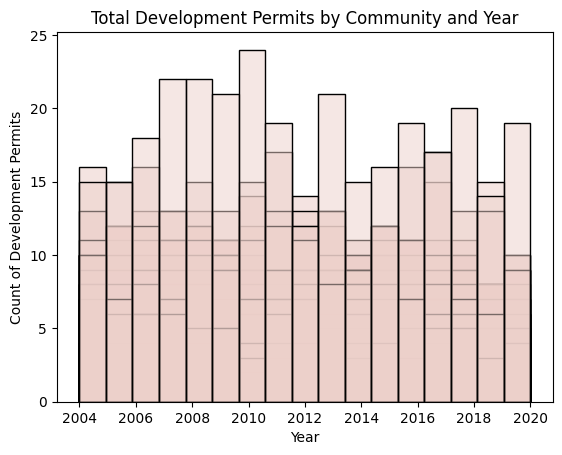

In [21]:
# Histogram
fig = sns.histplot(x='Year', hue='NumPermits', data=pandas_df)
plt.title('Total Development Permits by Community and Year')
fig.set(ylabel='Count of Development Permits')
fig.legend_.remove()

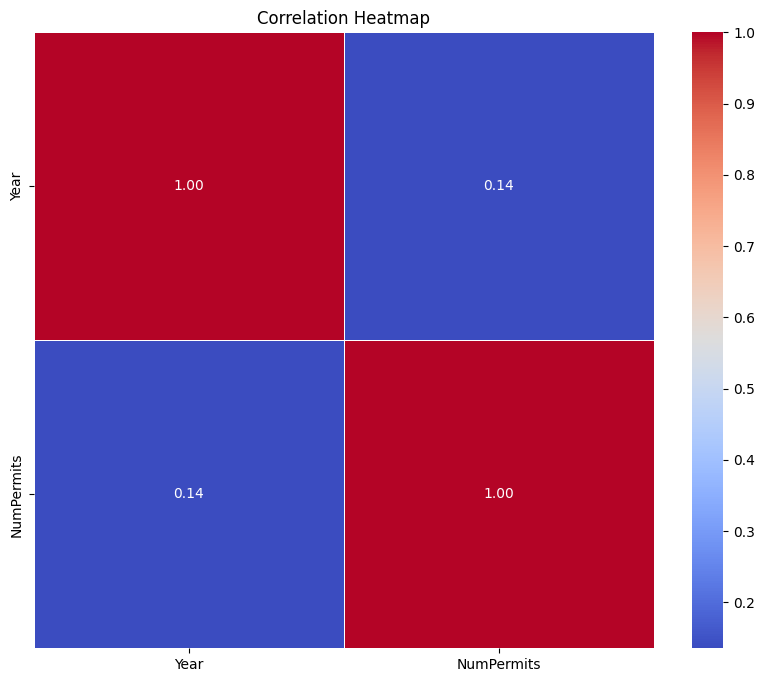

In [22]:
# Drop the non-numeric columns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df_EDA = df.drop('CommCode')

# Combine features into a single vector column
vector_assembler = VectorAssembler(
    inputCols=df_EDA.columns, outputCol="features")
df_vectorized = vector_assembler.transform(df_EDA)

# Compute correlation matrix
corr_matrix = Correlation.corr(df_vectorized, "features").head()

# Extract correlation matrix from the result
matrix = corr_matrix[0].toArray()

# Convert to Pandas DataFrame
corr_df = pd.DataFrame(matrix, columns=df_EDA.columns, index=df_EDA.columns)

# Plot heatmap using seaborn

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")

plt.show()

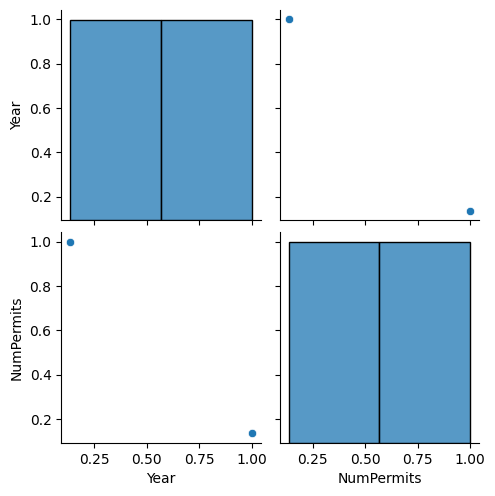

In [23]:
# Combine features into a single vector column
import pandas as pd
vector_assembler = VectorAssembler(
    inputCols=df_EDA.columns, outputCol="features")
df_vectorized = vector_assembler.transform(df_EDA)

# Compute correlation matrix
corr_matrix = Correlation.corr(df_vectorized, "features").head()

# Extract correlation matrix from the result
matrix = corr_matrix[0].toArray()

# Convert to Pandas DataFrame
corr_df = pd.DataFrame(matrix, columns=df_EDA.columns, index=df_EDA.columns)

# Pairplot
sns.pairplot(corr_df, kind='scatter')

plt.show()

In [26]:
# Stop the SparkContext
sc.stop()